In [29]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import re

In [30]:
url="https://en.wikipedia.org/wiki/List_of_Formula_One_World_Drivers%27_Champions"

In [31]:
try:
    response = requests.get(url,headers={"User-Agent":"Mozilla/5.0"})
    response.raise_for_status()
except requests.exceptions.RequestException as err:
    print("Error fetching the website:",err)
    exit()

In [32]:
soup=BeautifulSoup(response.text,"html.parser")

In [33]:
tables=soup.find_all("table",{"class":"wikitable"})

In [34]:
for i, table in enumerate(tables):
    headers = [header.text.strip() for header in table.find_all("th")]
    print(f"Table {i} headers: {headers}")

Table 0 headers: ['Bold']
Table 1 headers: ['Season', 'Driver', 'Age', 'Constructor', 'Tyres', 'Poles', 'Wins', 'Podiums', 'Fastest laps', 'Points', '% Points', 'Clinched[17]', '# of roundsremaining', 'Margin', '% Margin', 'Chassis', 'Engine', 'Season', 'Driver', 'Age', 'Chassis', 'Engine', 'Tyres', 'Poles', 'Wins', 'Podiums', 'Fastest laps', 'Points', '% Points', 'Clinched', '# of roundsremaining', 'Margin', '% Margin', 'Constructor']
Table 2 headers: ['Driver', 'Titles', 'Season(s)', '34 drivers', '', '75 titles']
Table 3 headers: ['Country', 'Titles', 'Drivers', 'Seasons', 'By driver (titles)', '15 countries', '75 titles', '34 drivers', '', '']
Table 4 headers: ['', 'Driver', 'Age', 'Season', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Table 5 headers: ['', 'Driver', 'Age', 'Season', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Table 6 headers: ['Championships', 'Driver', 'Seasons', '5', '4', '2']
Table 7 headers: ['Championships', 'Drivers[a]', 'Years', '2', '1']
Table

In [35]:
if len(tables) < 1:
    print("No table")
    exit()

In [36]:
champions_table = None
for table in tables:
    headers = [header.text.strip() for header in table.find_all("th")]
    if "Season" in headers and "Driver" in headers:
        champions_table=table
        break

In [37]:
if not champions_table:
    print("Could not find champions table")
    exit()

In [38]:
headers = [header.text.strip() for header in champions_table.find_all("th")]
headers = [re.sub(r"[^a-zA-Z0-9]","_",col) for col in headers]
print("Extracted headers:",headers)

Extracted headers: ['Season', 'Driver', 'Age', 'Constructor', 'Tyres', 'Poles', 'Wins', 'Podiums', 'Fastest_laps', 'Points', '__Points', 'Clinched_17_', '__of_roundsremaining', 'Margin', '__Margin', 'Chassis', 'Engine', 'Season', 'Driver', 'Age', 'Chassis', 'Engine', 'Tyres', 'Poles', 'Wins', 'Podiums', 'Fastest_laps', 'Points', '__Points', 'Clinched', '__of_roundsremaining', 'Margin', '__Margin', 'Constructor']


In [39]:
data=[]
for row in champions_table.find_all("tr")[1:]:
    cols=row.find_all("td")
    cols=[ele.text.strip() for ele in cols]
    if cols:
        data.append(cols)

In [40]:
for row in data[:5]:
    print("Row Length:",len(row),"Data:",row)

Row Length: 16 Data: ['1950', 'Giuseppe Farina[21]', '44', 'Alfa Romeo', 'Alfa Romeo', 'P', '2', '3', '3', '3', '30', '83.333 (47.619)', 'Round 7 of 7', '0', '3', '10.000']
Row Length: 16 Data: ['1951', 'Juan Manuel Fangio[22]', '40', 'Alfa Romeo', 'Alfa Romeo', 'P', '4', '3', '5', '5', '31', '86.111 (51.389)', 'Round 8 of 8', '0', '6', '19.355']
Row Length: 16 Data: ['1952[a]', 'Alberto Ascari[24]', '34', 'Ferrari', 'Ferrari', 'F P', '5', '6', '6', '6', '36', '100.000 (74.306)', 'Round 6 of 8', '2', '12', '33.333']
Row Length: 16 Data: ['1953[a]', 'Alberto Ascari[24]', '35', 'Ferrari', 'Ferrari', 'P', '6', '5', '5', '4', '34.5', '95.833 (57.407)', 'Round 8 of 9', '1', '6.5', '18.841']
Row Length: 16 Data: ['1954', 'Juan Manuel Fangio[22]', '43', 'Maserati[b]', 'Maserati', 'P', '5', '6', '7', '3', '42', '93.333 (70.547)', 'Round 7 of 9', '2', '16.857', '40.136']


In [41]:
df=pd.DataFrame(data,columns=headers[:len(data[0])])

In [42]:
df.to_csv("f1_world_champions.csv",index=False)

In [43]:
conn=sqlite3.connect("f1_champions.db")
cursor=conn.cursor()

In [44]:
columns_sql=", ".join([f'"{col}" TEXT' for col in df.columns])
cursor.execute(f'''CREATE TABLE IF NOT EXISTS champions ({columns_sql})''')

In [45]:
df.to_sql("champions", conn, if_exists="replace", index=False)
conn.commit()

In [46]:
query= "SELECT * FROM champions"
df_sql = pd.read_sql(query,conn)
conn.close()

In [47]:
print("Data retrieved from SQLite database:")
print(df_sql.head())

Data retrieved from SQLite database:
    Season                  Driver Age  Constructor       Tyres Poles Wins  \
0     1950     Giuseppe Farina[21]  44   Alfa Romeo  Alfa Romeo     P    2   
1     1951  Juan Manuel Fangio[22]  40   Alfa Romeo  Alfa Romeo     P    4   
2  1952[a]      Alberto Ascari[24]  34      Ferrari     Ferrari   F P    5   
3  1953[a]      Alberto Ascari[24]  35      Ferrari     Ferrari     P    6   
4     1954  Juan Manuel Fangio[22]  43  Maserati[b]    Maserati     P    5   

  Podiums Fastest_laps Points __Points      Clinched_17_ __of_roundsremaining  \
0       3            3      3       30   83.333 (47.619)         Round 7 of 7   
1       3            5      5       31   86.111 (51.389)         Round 8 of 8   
2       6            6      6       36  100.000 (74.306)         Round 6 of 8   
3       5            5      4     34.5   95.833 (57.407)         Round 8 of 9   
4       6            7      3       42   93.333 (70.547)         Round 7 of 9   

  Margi

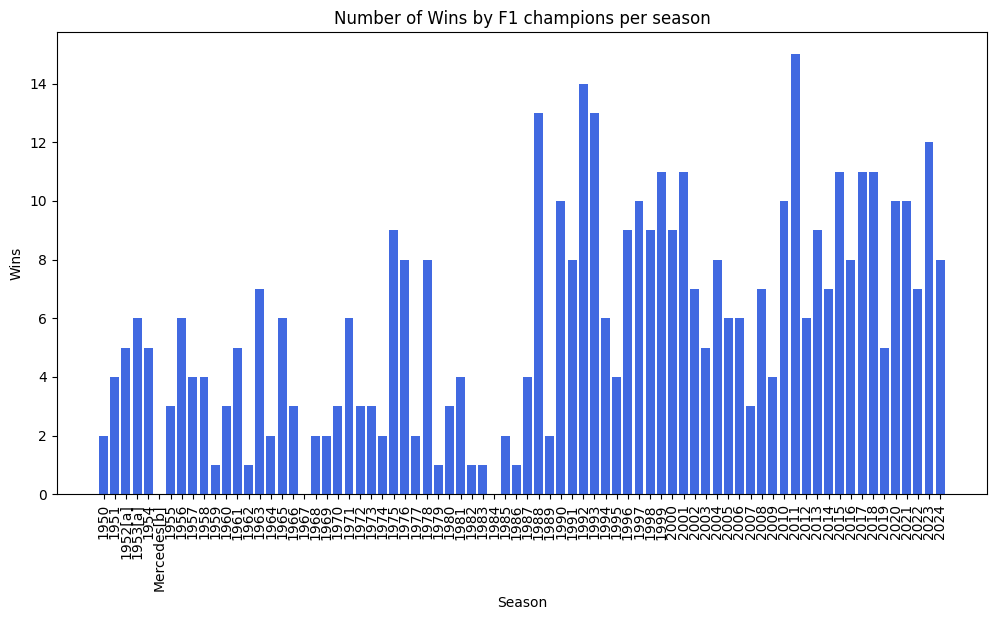

,Season,Driver,Age,Constructor,Tyres,Poles,Wins,Podiums,Fastest_laps,Points,__Points,Clinched_17_,__of_roundsremaining,Margin,__Margin,Chassis
0,1950,Giuseppe Farina[21],44,Alfa Romeo,Alfa Romeo,P,2,3,3,3,30,83.333 (47.619),Round 7 of 7,0,3,10.000
1,1951,Juan Manuel Fangio[22],40,Alfa Romeo,Alfa Romeo,P,4,3,5,5,31,86.111 (51.389),Round 8 of 8,0,6,19.355
2,1952[a],Alberto Ascari[24],34,Ferrari,Ferrari,F P,5,6,6,6,36,100.000 (74.306),Round 6 of 8,2,12,33.333
3,1953[a],Alberto Ascari[24],35,Ferrari,Ferrari,P,6,5,5,4,34.5,95.833 (57.407),Round 8 of 9,1,6.5,18.841
4,1954,Juan Manuel Fangio[22],43,Maserati[b],Maserati,P,5,6,7,3,42,93.333 (70.547),Round 7 of 9,2,16.857,40.136


In [51]:
plt.figure(figsize=(12,6))
df["Season"] = df["Season"].astype(str)
if "Wins" in df.columns:
    plt.bar(df["Season"],pd.to_numeric(df["Wins"],errors='coerce').fillna(0), color="royalblue")
    plt.xlabel("Season")
    plt.ylabel("Wins")
    plt.title("Number of Wins by F1 champions per season")
    plt.xticks(rotation=90)
    plt.show()
df.head()